In [1]:
import shared_functions
#下面用到什么定义就从shared_functions中载入
from shared_functions import read_from_files
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random
import torch
import sklearn
from sklearn import *
from shared_functions import performance_assessment
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost
# For imbalanced learning
import imblearn
import warnings
warnings.filterwarnings('ignore')
from shared_functions import training_loop
import math
import torch.nn as nn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
DIR_INPUT='D:/Credit Card Fraud Detection/simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 984 ms
Wall time: 2.04 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [3]:
from shared_functions import get_train_test_set, scaleData
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test
start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)
# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

In [4]:
train_df['CUSTOMER_ID'].value_counts()  # To count occurrences of each customer ID
train_df['TX_FRAUD'].value_counts()  # To count occurrences of each fraud label (1 or 0)

TX_FRAUD
0    66295
1      633
Name: count, dtype: int64

In [9]:
valid_df['CUSTOMER_ID'].value_counts()  # To count occurrences of each customer ID
valid_df['TX_FRAUD'].value_counts()  # To count occurrences of each fraud label (1 or 0)

TX_FRAUD
0    58131
1      374
Name: count, dtype: int64

In [10]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Selected device is cuda


In [11]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

In [12]:
print(len(x_train))
print(len(x_valid))

66928
58505


In [13]:
# new Dataset: FraudDatasetUnsupervised, which only receives the descriptive features of the transaction x
# and returns it as both input and output.去掉标签的数据
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [14]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [15]:
from shared_functions import prepare_generators

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

In [16]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [17]:
criterion = torch.nn.MSELoss().to(DEVICE)

In [18]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [19]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)#每个样本的loss这样有助于发现异常值

In [20]:
print(x_train.shape[1])

15


In [21]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572418479402026
valid loss: 0.11789108314475075
New best score: 0.11789108314475075

Epoch 1: train loss: 0.08445224534705936
valid loss: 0.0447379731822535
New best score: 0.0447379731822535

Epoch 2: train loss: 0.0381344485908647
valid loss: 0.028129147312761657
New best score: 0.028129147312761657

Epoch 3: train loss: 0.023945544768894093
valid loss: 0.016839703536831615
New best score: 0.016839703536831615

Epoch 4: train loss: 0.013857111910422177
valid loss: 0.009604522070842362
New best score: 0.009604522070842362

Epoch 5: train loss: 0.0076831335657726735
valid loss: 0.005340844840116677
New best score: 0.005340844840116677

Epoch 6: train loss: 0.005278851725178883
valid loss: 0.004115554313506178
New best score: 0.004115554313506178

Epoch 7: train loss: 0.0040532457875978225
valid loss: 0.003135783030890702
New best score: 0.003135783030890702

Epoch 8: train loss: 0.0030778856732326973
valid loss: 0.0025028832521432082
New best score: 0.00250288

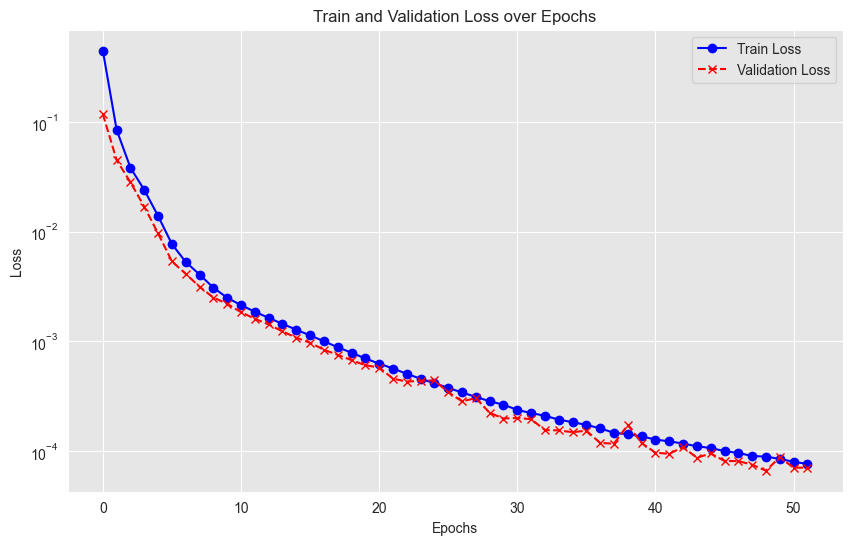

In [39]:
plt.figure(figsize=(10, 6))
plt.yscale('log')    
    # Plot training loss
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    
    # Plot validation loss
plt.plot(valid_losses, label='Validation Loss', color='red', linestyle='--', marker='x')
    
    # Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
    
    # Adding legend
plt.legend()
    
    # Displaying the plot
plt.grid(True)
plt.show()

In [40]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.268305e-05, 2.8324459e-05, 3.6242367e-05, 4.6025445e-05, 3.5767283e-05]
7.0288675e-05


In [41]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1358, -0.6267,  2.1802, -0.2965,  0.1197, -1.6986,  0.5020, -1.6774,
        -0.0492, -0.9771, -0.0745, -1.9801, -0.1176, -0.9701, -0.1372],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [42]:
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0013673021
Average genuine reconstruction error: 6.194402e-05


In [43]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.163,0.199


In [18]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572418479402026
valid loss: 0.11789108314475075

Epoch 1: train loss: 0.08445224534705936
valid loss: 0.0447379731822535

Epoch 2: train loss: 0.0381344485908647
valid loss: 0.028129147312761657

Epoch 3: train loss: 0.023945544768894093
valid loss: 0.016839703536831615

Epoch 4: train loss: 0.013857111910422177
valid loss: 0.009604522070842362

Epoch 5: train loss: 0.0076831335657726735
valid loss: 0.005340844840116677

Epoch 6: train loss: 0.005278851725178883
valid loss: 0.004115554313506178

Epoch 7: train loss: 0.0040532457875978225
valid loss: 0.003135783030890702

Epoch 8: train loss: 0.0030778856732326973
valid loss: 0.0025028832521432082

Epoch 9: train loss: 0.002488708328571434
valid loss: 0.002192020507610805

Epoch 10: train loss: 0.0021338627867785284
valid loss: 0.0018393649893324272

Epoch 11: train loss: 0.0018570574044328304
valid loss: 0.0016023421412603572

Epoch 12: train loss: 0.0016329493582868382
valid loss: 0.0014210561136435208

Epoch

In [19]:
losses = per_sample_mse(model, valid_generator)
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]

predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.826,0.203,0.213


In [20]:
#times 3-5
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(model, valid_generator)
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]

predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.45422687944929413
valid loss: 0.12894586210693817

Epoch 1: train loss: 0.08152918599681291
valid loss: 0.03685439380465961

Epoch 2: train loss: 0.03230971203276435
valid loss: 0.02280476830818288

Epoch 3: train loss: 0.02024140623691946
valid loss: 0.015375482980060121

Epoch 4: train loss: 0.013718343801960263
valid loss: 0.009952318635285715

Epoch 5: train loss: 0.007822610582777051
valid loss: 0.005638878785145006

Epoch 6: train loss: 0.005654289083106596
valid loss: 0.004454206317011776

Epoch 7: train loss: 0.004475726064002537
valid loss: 0.003574431736449726

Epoch 8: train loss: 0.003347972365533381
valid loss: 0.0028346886128044683

Epoch 9: train loss: 0.002564369089501673
valid loss: 0.002163566168921852

Epoch 10: train loss: 0.002122024398178653
valid loss: 0.001822556639497316

Epoch 11: train loss: 0.0018212972301232984
valid loss: 0.001563971955011105

Epoch 12: train loss: 0.0015702277220394746
valid loss: 0.0013443756321842065

Epoch 13: t

,AUC ROC,Average precision,Card Precision@100
0,0.846,0.207,0.217


In [21]:
#times 4t
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(model, valid_generator)
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]

predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4689786931638736
valid loss: 0.1301681047498854

Epoch 1: train loss: 0.08517064454379433
valid loss: 0.04604199326551352

Epoch 2: train loss: 0.03410492722126682
valid loss: 0.02291273770171925

Epoch 3: train loss: 0.0206713966978981
valid loss: 0.014920209819461154

Epoch 4: train loss: 0.013029720237118906
valid loss: 0.008697265477169081

Epoch 5: train loss: 0.008015196998363243
valid loss: 0.006037756133458165

Epoch 6: train loss: 0.006434757338817201
valid loss: 0.005238426419209099

Epoch 7: train loss: 0.005723278248107442
valid loss: 0.004707265647046798

Epoch 8: train loss: 0.0051050047910136545
valid loss: 0.003954569946801483

Epoch 9: train loss: 0.0040727950092565345
valid loss: 0.0030419518669833087

Epoch 10: train loss: 0.0029138013437598675
valid loss: 0.0021756937527581234

Epoch 11: train loss: 0.0021508927636220694
valid loss: 0.0017918891312880187

Epoch 12: train loss: 0.0017768347281499643
valid loss: 0.0015983455989998384

Epoch 13:

,AUC ROC,Average precision,Card Precision@100
0,0.836,0.225,0.219


In [22]:
#5 times
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(model, valid_generator)
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]

predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4411845276520425
valid loss: 0.10986274168139598

Epoch 1: train loss: 0.0715612075264863
valid loss: 0.03767787413315369

Epoch 2: train loss: 0.03400281417926143
valid loss: 0.02447608736409841

Epoch 3: train loss: 0.021289467847199102
valid loss: 0.014377759158855578

Epoch 4: train loss: 0.011936421004830937
valid loss: 0.007902428021277887

Epoch 5: train loss: 0.00744505268882205
valid loss: 0.005848129038174784

Epoch 6: train loss: 0.006221877642725568
valid loss: 0.005016430583146345

Epoch 7: train loss: 0.0055168180018182605
valid loss: 0.004531236750943983

Epoch 8: train loss: 0.004976080374633733
valid loss: 0.00404497275531007

Epoch 9: train loss: 0.004397635781749313
valid loss: 0.0036352205650036127

Epoch 10: train loss: 0.0036741035896260825
valid loss: 0.002883513334660175

Epoch 11: train loss: 0.002812861494077138
valid loss: 0.0022386818732353835

Epoch 12: train loss: 0.0021534053925745347
valid loss: 0.00183376192173773

Epoch 13: trai

,AUC ROC,Average precision,Card Precision@100
0,0.834,0.196,0.207


In [29]:
# AUC ROC 0.8364 ± 0.003   ReLU
# Card Precision@100  0.211 ± 0.003

In [30]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=42)

In [31]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.808,0.164,0.19


Confusion Matrix:
[[52535  5596]
 [  119   255]]
True Positives: 255
False Positives: 5596
True Negatives: 52535
False Negatives: 119


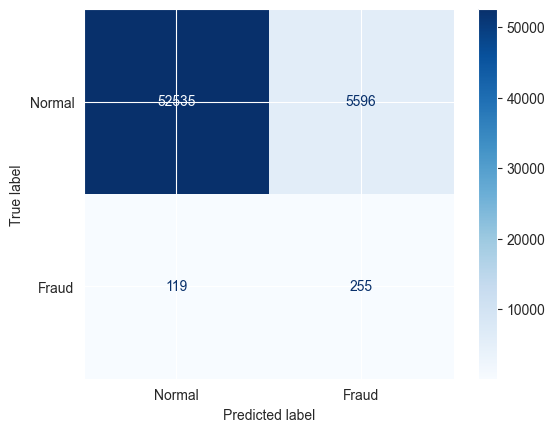

Average fraud reconstruction error: 0.0013673021
Average genuine reconstruction error: 6.194402e-05


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Blues')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))



In [53]:
print(classification_report(y_valid, y_pred))
roc_auc = roc_auc_score(y_valid, y_pred)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     58131
         1.0       0.04      0.68      0.08       374

    accuracy                           0.90     58505
   macro avg       0.52      0.79      0.52     58505
weighted avg       0.99      0.90      0.94     58505

ROC AUC Score:  0.7927764250337404


Confusion Matrix:
[[52539  5592]
 [  115   259]]
True Positives: 259
False Positives: 5592
True Negatives: 52539
False Negatives: 115


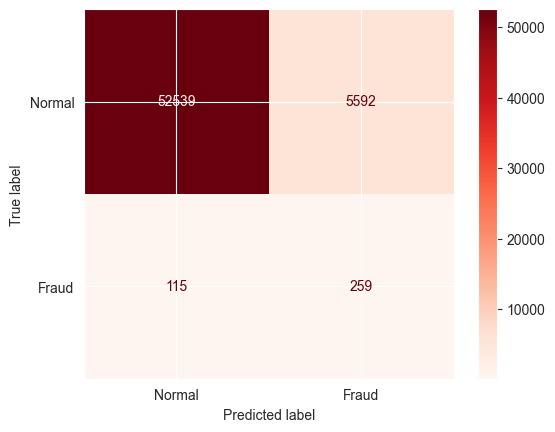

Average fraud reconstruction error: 0.0015619656
Average genuine reconstruction error: 9.333908e-05


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [33]:
Accuracy (准确率) ≈ 0.904
Precision (精确率) ≈ 0.044
Recall (召回率) ≈ 0.692
F1-Score ≈ 0.083
Specificity (特异度) ≈ 0.903
False Positive Rate (假阳性率) ≈ 0.096
False Negative Rate (假阴性率) ≈ 0.307

SyntaxError: invalid character '≈' (U+2248) (2436469210.py, line 1)

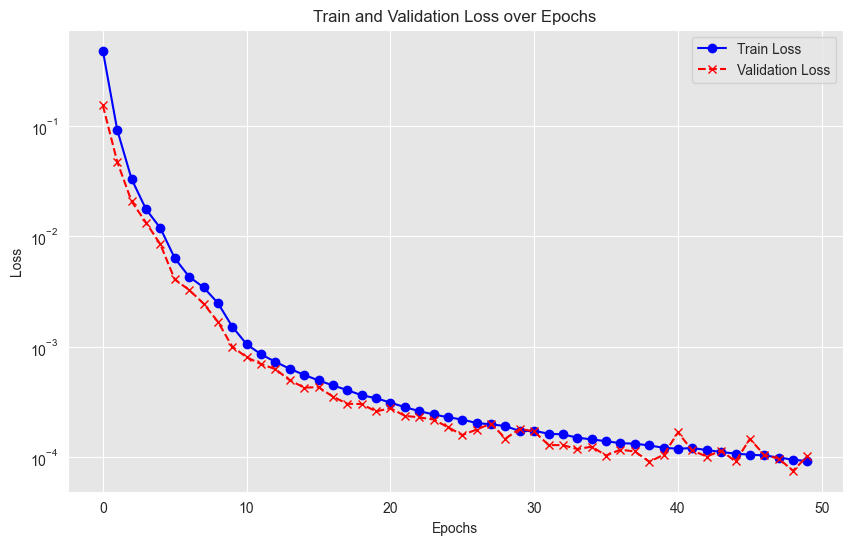

In [37]:
plt.figure(figsize=(10, 6))
plt.yscale('log')    
    # Plot training loss
plt.plot(train_lossesG, label='Train Loss', color='blue', linestyle='-', marker='o')
    
    # Plot validation loss
plt.plot(valid_lossesG, label='Validation Loss', color='red', linestyle='--', marker='x')
    
    # Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
    
    # Adding legend
plt.legend()
    
    # Displaying the plot
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(classification_report(y_valid, y_pred))
roc_auc = roc_auc_score(y_valid, y_pred)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     58131
         1.0       0.04      0.69      0.08       374

    accuracy                           0.90     58505
   macro avg       0.52      0.80      0.52     58505
weighted avg       0.99      0.90      0.94     58505

ROC AUC Score:  0.7981584236672895


In [47]:
#########改初值
#############
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=0.5):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.5):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)


Epoch 0: train loss: 0.4420469033230901
valid loss: 0.11140690353073057

Epoch 1: train loss: 0.07517300159750545
valid loss: 0.03977502909148

Epoch 2: train loss: 0.029419197542432617
valid loss: 0.017647975290326474

Epoch 3: train loss: 0.014207540283845042
valid loss: 0.00916413855560816

Epoch 4: train loss: 0.007844534772047577
valid loss: 0.005495424914463866

Epoch 5: train loss: 0.005466894069009854
valid loss: 0.0040693391242975505

Epoch 6: train loss: 0.004088245959169842
valid loss: 0.0032305770239390717

Epoch 7: train loss: 0.0029112581367538547
valid loss: 0.0020700234737847756

Epoch 8: train loss: 0.001992721781361649
valid loss: 0.0015155066229667656

Epoch 9: train loss: 0.0014812255882120284
valid loss: 0.0011078341778169279

Epoch 10: train loss: 0.00120312226211686
valid loss: 0.0010520818785769365

Epoch 11: train loss: 0.001001496634795108
valid loss: 0.0007773612704143295

Epoch 12: train loss: 0.0008459385541440424
valid loss: 0.0007070219199252035

Epoch 1

In [48]:
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

[3.047737e-05, 4.1591647e-05, 0.000113189475, 2.7189413e-05, 0.00012209086]
8.50918e-05
Average fraud reconstruction error: 0.0021115248
Average genuine reconstruction error: 7.2054245e-05


In [49]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.85,0.239,0.231


Confusion Matrix:
[[52542  5589]
 [  112   262]]
True Positives: 262
False Positives: 5589
True Negatives: 52542
False Negatives: 112


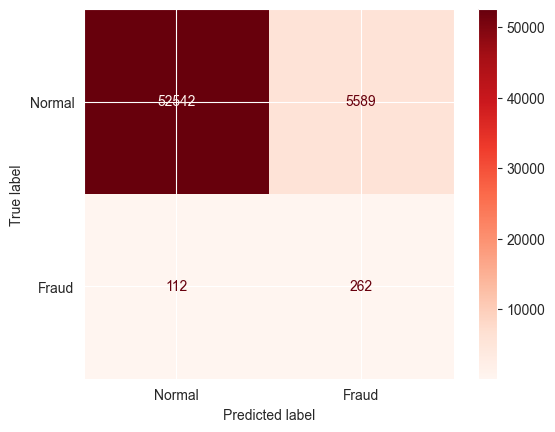

Average fraud reconstruction error: 0.0026244575
Average genuine reconstruction error: 0.00010067409


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [53]:
print(modelG.gelu1.sigma)  # prints the sigma value of the first GELU
print(modelG.gelu2.sigma)  # prints the sigma value of the second GELU
print(modelG.gelu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.3072, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0632, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.1169, device='cuda:0', requires_grad=True)


In [23]:
class GELU(nn.Module):
    def __init__(self, init_sigma=0.7):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.8):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.44457689595068617
valid loss: 0.12332185569519553

Epoch 1: train loss: 0.07362263925359308
valid loss: 0.03499914104821252

Epoch 2: train loss: 0.027777323407614265
valid loss: 0.018119175993720364

Epoch 3: train loss: 0.014298110375853957
valid loss: 0.008232466094297626

Epoch 4: train loss: 0.007075583123081999
valid loss: 0.0049826894548360276

Epoch 5: train loss: 0.005108765550144729
valid loss: 0.003837982876496033

Epoch 6: train loss: 0.004071361544995211
valid loss: 0.0030523606887738644

Epoch 7: train loss: 0.0031583663097308526
valid loss: 0.002237501013273363

Epoch 8: train loss: 0.0022049277566660937
valid loss: 0.0015035492053148566

Epoch 9: train loss: 0.0014636471749476584
valid loss: 0.0010431138614429253

Epoch 10: train loss: 0.001085198731604611
valid loss: 0.0008040773271979978

Epoch 11: train loss: 0.0008849554914608508
valid loss: 0.000702685930211443

Epoch 12: train loss: 0.0007477026146945204
valid loss: 0.0005641285767568825

E

,AUC ROC,Average precision,Card Precision@100
0,0.851,0.245,0.227


In [25]:
#########改初值
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=0.6):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.5):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)

losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4395907219627562
valid loss: 0.10023909630915506

Epoch 1: train loss: 0.06372247799967432
valid loss: 0.03509167999924858

Epoch 2: train loss: 0.031077044202196438
valid loss: 0.019943887163258966

Epoch 3: train loss: 0.0159604122290605
valid loss: 0.010145945168644841

Epoch 4: train loss: 0.008689529762200898
valid loss: 0.006020719029742186

Epoch 5: train loss: 0.005826048081318704
valid loss: 0.004279343197834703

Epoch 6: train loss: 0.004277008824583756
valid loss: 0.0031865983910074895

Epoch 7: train loss: 0.002978962507983937
valid loss: 0.0021387630826132016

Epoch 8: train loss: 0.001982732942689791
valid loss: 0.001508579470784673

Epoch 9: train loss: 0.0014680047547551546
valid loss: 0.0011035616327677675

Epoch 10: train loss: 0.0011833800807544948
valid loss: 0.0009174100832652321

Epoch 11: train loss: 0.0009891124899979026
valid loss: 0.0008536216937758721

Epoch 12: train loss: 0.0008407173904543119
valid loss: 0.000680655876144034

Epoch 

,AUC ROC,Average precision,Card Precision@100
0,0.854,0.248,0.233


In [27]:
#########改初值
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=0.5):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.5):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)

losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4366600010935823
valid loss: 0.10293834935364828

Epoch 1: train loss: 0.06810469274368158
valid loss: 0.03808689981373282

Epoch 2: train loss: 0.030445288454519003
valid loss: 0.020297828416436747

Epoch 3: train loss: 0.01630885389911271
valid loss: 0.010293005851652126

Epoch 4: train loss: 0.008577792866762735
valid loss: 0.005995354061193072

Epoch 5: train loss: 0.005887047702626434
valid loss: 0.004334646383748273

Epoch 6: train loss: 0.00440105806611457
valid loss: 0.0032961431235492313

Epoch 7: train loss: 0.003176197696884072
valid loss: 0.002220155953943648

Epoch 8: train loss: 0.002157376663662301
valid loss: 0.001679891134329812

Epoch 9: train loss: 0.0015787558410188492
valid loss: 0.0012654488170875714

Epoch 10: train loss: 0.0012697764652528324
valid loss: 0.0010091632561976995

Epoch 11: train loss: 0.0010723709897572232
valid loss: 0.0008220717823641791

Epoch 12: train loss: 0.0009113320076693897
valid loss: 0.0008643179171962938

Epoch 

,AUC ROC,Average precision,Card Precision@100
0,0.853,0.254,0.236


In [28]:
###  0.850 ± 0.002  ---0.853, 0.851, 0.842, 0.85, 0.854;
### 0.2326 ± 0.0015  ----0.236, 0.227, 0.236, 0.231, 0.233

Confusion Matrix:
[[52539  5592]
 [  115   259]]
True Positives: 259
False Positives: 5592
True Negatives: 52539
False Negatives: 115


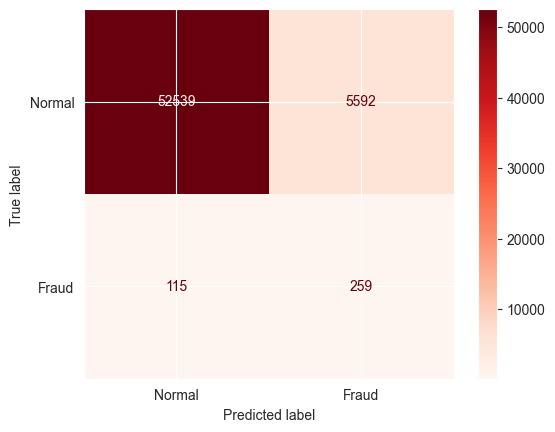

Average fraud reconstruction error: 0.0018327978
Average genuine reconstruction error: 0.00014125189


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [56]:
print(modelG.gelu1.sigma)  # prints the sigma value of the first GELU
print(modelG.gelu2.sigma)  # prints the sigma value of the second GELU
print(modelG.gelu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.3696, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0733, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.2155, device='cuda:0', requires_grad=True)


In [57]:
####################
###########SiLU
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.500212016129015
valid loss: 0.1814925249727046

Epoch 1: train loss: 0.12222507215651682
valid loss: 0.06434968374873119

Epoch 2: train loss: 0.04002108364357091
valid loss: 0.023043400237509788

Epoch 3: train loss: 0.019308568760182845
valid loss: 0.013238235264812988

Epoch 4: train loss: 0.011066224565818536
valid loss: 0.00667190967239643

Epoch 5: train loss: 0.005702006926423519
valid loss: 0.00395669007961399

Epoch 6: train loss: 0.004242292520199256
valid loss: 0.0032139300884007184

Epoch 7: train loss: 0.003497680617108172
valid loss: 0.0025762341807143447

Epoch 8: train loss: 0.0027609099966765917
valid loss: 0.0019325363601155863

Epoch 9: train loss: 0.0018223898249244705
valid loss: 0.0013742081308864627

Epoch 10: train loss: 0.0010651263983650437
valid loss: 0.0007475208918897364

Epoch 11: train loss: 0.0007883843931438041
valid loss: 0.0006094908731883961

Epoch 12: train loss: 0.0006565168105347624
valid loss: 0.0005121053439975955

Epoch 

,AUC ROC,Average precision,Card Precision@100
0,0.851,0.286,0.23


Confusion Matrix:
[[52546  5585]
 [  108   266]]
True Positives: 266
False Positives: 5585
True Negatives: 52546
False Negatives: 108


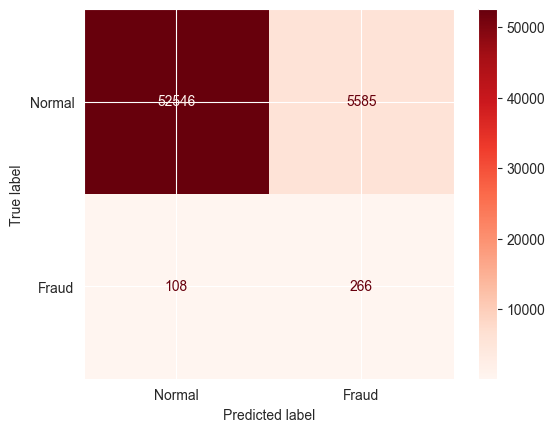

Average fraud reconstruction error: 0.001937864
Average genuine reconstruction error: 6.207694e-05


In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [32]:
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4904673237845045
valid loss: 0.18702537816404644

Epoch 1: train loss: 0.11340909040965724
valid loss: 0.06148226782679558

Epoch 2: train loss: 0.04466671683072303
valid loss: 0.02662420063457691

Epoch 3: train loss: 0.022513286616603345
valid loss: 0.01564032250170499

Epoch 4: train loss: 0.01221814615666211
valid loss: 0.006975758572673944

Epoch 5: train loss: 0.005845829094786831
valid loss: 0.00395329716854571

Epoch 6: train loss: 0.00399856877401489
valid loss: 0.002836880226787485

Epoch 7: train loss: 0.0027418287603823864
valid loss: 0.0018009398060677766

Epoch 8: train loss: 0.0016764981275287246
valid loss: 0.0014097392678011434

Epoch 9: train loss: 0.0011604518457547356
valid loss: 0.0008857467175522422

Epoch 10: train loss: 0.0009244232841729085
valid loss: 0.0007264718968234193

Epoch 11: train loss: 0.0007824098056569129
valid loss: 0.0006098038091831917

Epoch 12: train loss: 0.000657989243531255
valid loss: 0.0005526257456373169

Epoch 13

,AUC ROC,Average precision,Card Precision@100
0,0.848,0.284,0.233


In [15]:
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.1):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.1):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.5059158609571011
valid loss: 0.18520805163950216

Epoch 1: train loss: 0.13945363859430554
valid loss: 0.08086655941572997

Epoch 2: train loss: 0.05785991282809533
valid loss: 0.03348024501338031

Epoch 3: train loss: 0.02817708023522854
valid loss: 0.020976170297976725

Epoch 4: train loss: 0.0189867919492562
valid loss: 0.014094970182927906

Epoch 5: train loss: 0.01093968147537484
valid loss: 0.006271327957205596

Epoch 6: train loss: 0.005729941402145272
valid loss: 0.0040715636920865845

Epoch 7: train loss: 0.004285668587867691
valid loss: 0.003206428933425557

Epoch 8: train loss: 0.0034215817717438203
valid loss: 0.002541787771614971

Epoch 9: train loss: 0.002551770434560375
valid loss: 0.0017988532449531019

Epoch 10: train loss: 0.0016084273698464585
valid loss: 0.001095049622433026

Epoch 11: train loss: 0.0010232994947874077
valid loss: 0.0007584812413822208

Epoch 12: train loss: 0.0007898747220606032
valid loss: 0.0006641392546287315

Epoch 13: t

,AUC ROC,Average precision,Card Precision@100
0,0.856,0.273,0.229


In [37]:
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.1):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.1):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4980679334392397
valid loss: 0.16821346801649678

Epoch 1: train loss: 0.11341773362449205
valid loss: 0.06983880020800184

Epoch 2: train loss: 0.052925283465014475
valid loss: 0.028841824206661006

Epoch 3: train loss: 0.023289292427509965
valid loss: 0.017005367446792582

Epoch 4: train loss: 0.013617358271061064
valid loss: 0.008412854055380397

Epoch 5: train loss: 0.006713640866988119
valid loss: 0.004517023922885702

Epoch 6: train loss: 0.004676739594086214
valid loss: 0.003450732576391085

Epoch 7: train loss: 0.0038969802877636016
valid loss: 0.0030130680011778745

Epoch 8: train loss: 0.003318038447978185
valid loss: 0.0024412422775560634

Epoch 9: train loss: 0.002567437816082712
valid loss: 0.0017148696070618398

Epoch 10: train loss: 0.001508003697743066
valid loss: 0.0009032346131381848

Epoch 11: train loss: 0.0008881672403581946
valid loss: 0.0007274375103103618

Epoch 12: train loss: 0.0007113625918465833
valid loss: 0.0005426795208665079

Epoc

,AUC ROC,Average precision,Card Precision@100
0,0.854,0.274,0.236


In [20]:
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.1):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4862664210579819
valid loss: 0.18540461076413348

Epoch 1: train loss: 0.12428645967696411
valid loss: 0.06306654628915864

Epoch 2: train loss: 0.04264414133272538
valid loss: 0.027099311721251636

Epoch 3: train loss: 0.022868913583222412
valid loss: 0.01591569127952629

Epoch 4: train loss: 0.011658684511261192
valid loss: 0.006157599347312756

Epoch 5: train loss: 0.005781183091177468
valid loss: 0.0041143486252095286

Epoch 6: train loss: 0.004404171007924872
valid loss: 0.003543804488857302

Epoch 7: train loss: 0.0035327011837319507
valid loss: 0.0025783360767804206

Epoch 8: train loss: 0.0026512306142285873
valid loss: 0.0017863128653630776

Epoch 9: train loss: 0.0016654072515043228
valid loss: 0.0010495610629294902

Epoch 10: train loss: 0.0010479611022879563
valid loss: 0.0008146242681659168

Epoch 11: train loss: 0.0008164009349618773
valid loss: 0.0006824373415177638

Epoch 12: train loss: 0.0006867377788915137
valid loss: 0.0005748120950353001

Ep

,AUC ROC,Average precision,Card Precision@100
0,0.861,0.225,0.23


In [21]:
#0.855+0.001   0.861,0.854,0.856,0.853,0.851
#0.2304+0.003 0.23,0.236,0.229,0.227,0.23

In [2]:
#############2024-12-01 补充的实验

In [18]:
class PMish(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(PMish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        # Original Mish: x * tanh(softplus(x))
        # Parameterized version: x * tanh(softplus(x / sigma))
        softplus = torch.nn.functional.softplus(input / self.sigma)
        tanh_softplus = torch.tanh(softplus)
        output = input * tanh_softplus
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.PMish1 = PMish(init_sigma=init_sigma)  
            self.PMish2 = PMish(init_sigma=init_sigma)
            self.PMish3 = PMish(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.PMish1(hidden)
            
            code = self.fc2(hidden)
            code = self.PMish2(code)
 
            hidden = self.fc3(code)
            hidden = self.PMish3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.45709166412970076
valid loss: 0.14047238889450583

Epoch 1: train loss: 0.09658229418355352
valid loss: 0.05024937269751166

Epoch 2: train loss: 0.038521750134738235
valid loss: 0.02252161613375437

Epoch 3: train loss: 0.0159912835370329
valid loss: 0.00777206568485075

Epoch 4: train loss: 0.006642103212107379
valid loss: 0.004520331347320493

Epoch 5: train loss: 0.004557278438539816
valid loss: 0.0032731934698664996

Epoch 6: train loss: 0.0032842075980863182
valid loss: 0.0022370013035579376

Epoch 7: train loss: 0.002095433075139459
valid loss: 0.0014035496519130394

Epoch 8: train loss: 0.0013155819895257906
valid loss: 0.0010176331734238957

Epoch 9: train loss: 0.001010273918623005
valid loss: 0.0009023357017342347

Epoch 10: train loss: 0.0008251284795922777
valid loss: 0.00072365521257387

Epoch 11: train loss: 0.0007013375080683862
valid loss: 0.0005683746408509559

Epoch 12: train loss: 0.0006097028319143831
valid loss: 0.0004884673932807703

Epoch

,AUC ROC,Average precision,Card Precision@100
0,0.847,0.303,0.239


In [17]:
class PMish(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(PMish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        # Original Mish: x * tanh(softplus(x))
        # Parameterized version: x * tanh(softplus(x / sigma))
        softplus = torch.nn.functional.softplus(input / self.sigma)
        tanh_softplus = torch.tanh(softplus)
        output = input * tanh_softplus
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.PMish1 = PMish(init_sigma=init_sigma)  
            self.PMish2 = PMish(init_sigma=init_sigma)
            self.PMish3 = PMish(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.PMish1(hidden)
            
            code = self.fc2(hidden)
            code = self.PMish2(code)
 
            hidden = self.fc3(code)
            hidden = self.PMish3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.443615408069374
valid loss: 0.13527674905426515

Epoch 1: train loss: 0.09620105572059096
valid loss: 0.048918462797103685

Epoch 2: train loss: 0.034337613723609405
valid loss: 0.020894478052813824

Epoch 3: train loss: 0.016702623003702004
valid loss: 0.010108878747483747

Epoch 4: train loss: 0.007700937288371672
valid loss: 0.004499516918074564

Epoch 5: train loss: 0.00456990617989379
valid loss: 0.003406669889943155

Epoch 6: train loss: 0.0035356947606612872
valid loss: 0.0025170338562755883

Epoch 7: train loss: 0.00251406092497424
valid loss: 0.001627154941441583

Epoch 8: train loss: 0.0014969786311554087
valid loss: 0.000993135675903705

Epoch 9: train loss: 0.0009983234800532794
valid loss: 0.0007752322090237499

Epoch 10: train loss: 0.0008097178060136269
valid loss: 0.00062807066206403

Epoch 11: train loss: 0.0006842682283242806
valid loss: 0.0005315648795161498

Epoch 12: train loss: 0.0005983457565500159
valid loss: 0.0004883800225798041

Epoch 

,AUC ROC,Average precision,Card Precision@100
0,0.858,0.261,0.221


In [18]:
class PMish(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(PMish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        # Original Mish: x * tanh(softplus(x))
        # Parameterized version: x * tanh(softplus(x / sigma))
        softplus = torch.nn.functional.softplus(input / self.sigma)
        tanh_softplus = torch.tanh(softplus)
        output = input * tanh_softplus
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.PMish1 = PMish(init_sigma=init_sigma)  
            self.PMish2 = PMish(init_sigma=init_sigma)
            self.PMish3 = PMish(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.PMish1(hidden)
            
            code = self.fc2(hidden)
            code = self.PMish2(code)
 
            hidden = self.fc3(code)
            hidden = self.PMish3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4645331632452759
valid loss: 0.14136351960115745

Epoch 1: train loss: 0.08791857406169347
valid loss: 0.04408104520067165

Epoch 2: train loss: 0.03556341963622498
valid loss: 0.0236265960673654

Epoch 3: train loss: 0.01875609981499783
valid loss: 0.01210080698549829

Epoch 4: train loss: 0.009101445048986925
valid loss: 0.005146234253513031

Epoch 5: train loss: 0.004795876621107534
valid loss: 0.0034411423903243626

Epoch 6: train loss: 0.0033291732287167946
valid loss: 0.0022694267125169193

Epoch 7: train loss: 0.002127454440949937
valid loss: 0.0014385842271607185

Epoch 8: train loss: 0.0014099517997321325
valid loss: 0.0010692091816794534

Epoch 9: train loss: 0.0010882269651025808
valid loss: 0.0008356399045330905

Epoch 10: train loss: 0.0009017327591880575
valid loss: 0.000705148900198735

Epoch 11: train loss: 0.0007582878639180761
valid loss: 0.000606362063398259

Epoch 12: train loss: 0.0006542502155013954
valid loss: 0.000548737671046869

Epoch 1

,AUC ROC,Average precision,Card Precision@100
0,0.847,0.208,0.229


In [19]:
class PMish(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(PMish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        # Original Mish: x * tanh(softplus(x))
        # Parameterized version: x * tanh(softplus(x / sigma))
        softplus = torch.nn.functional.softplus(input / self.sigma)
        tanh_softplus = torch.tanh(softplus)
        output = input * tanh_softplus
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.PMish1 = PMish(init_sigma=init_sigma)  
            self.PMish2 = PMish(init_sigma=init_sigma)
            self.PMish3 = PMish(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.PMish1(hidden)
            
            code = self.fc2(hidden)
            code = self.PMish2(code)
 
            hidden = self.fc3(code)
            hidden = self.PMish3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4278155041584321
valid loss: 0.11653727705035705

Epoch 1: train loss: 0.07288935975515307
valid loss: 0.037409716408923675

Epoch 2: train loss: 0.027118596737139483
valid loss: 0.01650154860944696

Epoch 3: train loss: 0.012641001840426548
valid loss: 0.0073197509805911064

Epoch 4: train loss: 0.006366333696745464
valid loss: 0.004436763230701043

Epoch 5: train loss: 0.004670779066504003
valid loss: 0.0035121557614486154

Epoch 6: train loss: 0.0037502273840404137
valid loss: 0.002689123591866161

Epoch 7: train loss: 0.0027280244045849913
valid loss: 0.001795737698414653

Epoch 8: train loss: 0.0016409049131021608
valid loss: 0.001093338620041044

Epoch 9: train loss: 0.0011065529204357903
valid loss: 0.000874053820003272

Epoch 10: train loss: 0.0008967454466680742
valid loss: 0.0007105154458934675

Epoch 11: train loss: 0.0007575127007838172
valid loss: 0.0005925151087372956

Epoch 12: train loss: 0.0006606239339347437
valid loss: 0.0005780756001836554

E

,AUC ROC,Average precision,Card Precision@100
0,0.855,0.253,0.227


In [20]:
class PMish(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(PMish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        # Original Mish: x * tanh(softplus(x))
        # Parameterized version: x * tanh(softplus(x / sigma))
        softplus = torch.nn.functional.softplus(input / self.sigma)
        tanh_softplus = torch.tanh(softplus)
        output = input * tanh_softplus
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.PMish1 = PMish(init_sigma=init_sigma)  
            self.PMish2 = PMish(init_sigma=init_sigma)
            self.PMish3 = PMish(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.PMish1(hidden)
            
            code = self.fc2(hidden)
            code = self.PMish2(code)
 
            hidden = self.fc3(code)
            hidden = self.PMish3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4437799551960501
valid loss: 0.12687197812105136

Epoch 1: train loss: 0.09109436765840245
valid loss: 0.055472586198094115

Epoch 2: train loss: 0.03997878014799172
valid loss: 0.02374921122494617

Epoch 3: train loss: 0.018877198431288277
valid loss: 0.011710107699545518

Epoch 4: train loss: 0.009235322152230583
valid loss: 0.0052222080592351046

Epoch 5: train loss: 0.004907885599853809
valid loss: 0.003390469233876939

Epoch 6: train loss: 0.0032421350397880103
valid loss: 0.0021690634024568675

Epoch 7: train loss: 0.0020208331831084495
valid loss: 0.0014480805166365955

Epoch 8: train loss: 0.0014375127616795189
valid loss: 0.001076793921233506

Epoch 9: train loss: 0.0011503677592329222
valid loss: 0.0009270813696842152

Epoch 10: train loss: 0.0009656794080742231
valid loss: 0.0007368453836534173

Epoch 11: train loss: 0.0008194856668132879
valid loss: 0.0007029858423216279

Epoch 12: train loss: 0.0007111434125132017
valid loss: 0.000530852780510707

E

,AUC ROC,Average precision,Card Precision@100
0,0.857,0.277,0.233


In [3]:
#Mish# 0.857,0.855,0.847,0.858,0.847
## 0.233,0.227,0.229,0.221,0.239
#0.8528+-0.0053066
#0.2298+-0.006493

In [26]:
class TanhExp(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(TanhExp, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * torch.tanh(torch.exp(self.sigma * x))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4119795643890109
valid loss: 0.11952364099074582

Epoch 1: train loss: 0.0789838729882132
valid loss: 0.036743588149140444

Epoch 2: train loss: 0.030611775914317508
valid loss: 0.018647845716424326

Epoch 3: train loss: 0.013786716393353578
valid loss: 0.007304409321377187

Epoch 4: train loss: 0.00642985674658573
valid loss: 0.004598001309777381

Epoch 5: train loss: 0.004681560840149611
valid loss: 0.0034382705205206663

Epoch 6: train loss: 0.00343939725418235
valid loss: 0.0024271748919304603

Epoch 7: train loss: 0.002217393010945093
valid loss: 0.0014677512231079323

Epoch 8: train loss: 0.0013919576619000284
valid loss: 0.0010573596671310157

Epoch 9: train loss: 0.0010107705218452127
valid loss: 0.0007823745040999104

Epoch 10: train loss: 0.0007957013654840904
valid loss: 0.000599664968312489

Epoch 11: train loss: 0.0006336335914256674
valid loss: 0.000467032574697988

Epoch 12: train loss: 0.0005284982040501333
valid loss: 0.00044559851836520017

Epo

,AUC ROC,Average precision,Card Precision@100
0,0.843,0.299,0.236


In [27]:
class TanhExp(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(TanhExp, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * torch.tanh(torch.exp(self.sigma * x))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4020962838233087
valid loss: 0.10579232898810523

Epoch 1: train loss: 0.06578224725187908
valid loss: 0.032289986340888865

Epoch 2: train loss: 0.02576999130959749
valid loss: 0.015425978627442662

Epoch 3: train loss: 0.010804822841609328
valid loss: 0.005890718325616313

Epoch 4: train loss: 0.005764337751816738
valid loss: 0.004142295667148434

Epoch 5: train loss: 0.00411890043080633
valid loss: 0.0028717396649801745

Epoch 6: train loss: 0.0025721105666124187
valid loss: 0.001663501243567593

Epoch 7: train loss: 0.001513946340103272
valid loss: 0.001045349621960812

Epoch 8: train loss: 0.0010715202961173122
valid loss: 0.0007896131422062776

Epoch 9: train loss: 0.0008124492194222636
valid loss: 0.0006234505515490898

Epoch 10: train loss: 0.0006399892081529254
valid loss: 0.00048260812460294736

Epoch 11: train loss: 0.0005127498891297416
valid loss: 0.000410051862938238

Epoch 12: train loss: 0.000429658182059396
valid loss: 0.00036281483140366937

Ep

,AUC ROC,Average precision,Card Precision@100
0,0.851,0.252,0.227


In [28]:
class TanhExp(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(TanhExp, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * torch.tanh(torch.exp(self.sigma * x))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.40676876125469036
valid loss: 0.11070197765700153

Epoch 1: train loss: 0.0726591865719077
valid loss: 0.034617277886209594

Epoch 2: train loss: 0.02543458394549545
valid loss: 0.01582537866375648

Epoch 3: train loss: 0.012346483254181952
valid loss: 0.006907613549758095

Epoch 4: train loss: 0.005807038746065465
valid loss: 0.004075584863948691

Epoch 5: train loss: 0.0038317794076622915
valid loss: 0.0027697802139598814

Epoch 6: train loss: 0.002353884918008883
valid loss: 0.001569502229059288

Epoch 7: train loss: 0.0014748622257757511
valid loss: 0.0010733558447418297

Epoch 8: train loss: 0.0010381436781936823
valid loss: 0.0007560840476421345

Epoch 9: train loss: 0.00077105762701202
valid loss: 0.0005730743239579031

Epoch 10: train loss: 0.000594981225717405
valid loss: 0.00044609310016064025

Epoch 11: train loss: 0.00047125755012370147
valid loss: 0.0004029135219116639

Epoch 12: train loss: 0.0003883530157413441
valid loss: 0.0003449600968332427

E

,AUC ROC,Average precision,Card Precision@100
0,0.854,0.269,0.227


In [29]:
class TanhExp(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(TanhExp, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * torch.tanh(torch.exp(self.sigma * x))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.40940294926184767
valid loss: 0.11198395256950555

Epoch 1: train loss: 0.06684277253492556
valid loss: 0.029218912584696964

Epoch 2: train loss: 0.023302847350347454
valid loss: 0.01446869524165255

Epoch 3: train loss: 0.010097181151156273
valid loss: 0.005799128767866336

Epoch 4: train loss: 0.005666105362923235
valid loss: 0.004088607474479601

Epoch 5: train loss: 0.004203017483964869
valid loss: 0.0030203817684529093

Epoch 6: train loss: 0.002780355368522717
valid loss: 0.0017483659593714148

Epoch 7: train loss: 0.0015020154722735649
valid loss: 0.0010354872429717964

Epoch 8: train loss: 0.0009447063224950634
valid loss: 0.0007374676992185414

Epoch 9: train loss: 0.0007004175409403083
valid loss: 0.000550246047100327

Epoch 10: train loss: 0.0005450081050704923
valid loss: 0.0004357424111562257

Epoch 11: train loss: 0.0004441054144823687
valid loss: 0.0003402378086141906

Epoch 12: train loss: 0.00036330531244368753
valid loss: 0.0002850754580923605

,AUC ROC,Average precision,Card Precision@100
0,0.842,0.244,0.23


In [30]:
class TanhExp(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(TanhExp, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * torch.tanh(torch.exp(self.sigma * x))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4045942934055458
valid loss: 0.10153666713524385

Epoch 1: train loss: 0.06385316193837452
valid loss: 0.028429839174807722

Epoch 2: train loss: 0.01959554358638367
valid loss: 0.008753898285858618

Epoch 3: train loss: 0.007483361171822048
valid loss: 0.005294569006668088

Epoch 4: train loss: 0.005459817977805567
valid loss: 0.004125085829813135

Epoch 5: train loss: 0.00420053067995969
valid loss: 0.0029880361429217165

Epoch 6: train loss: 0.002935123673941135
valid loss: 0.0019088560561369595

Epoch 7: train loss: 0.00163964938237038
valid loss: 0.000992468646994685

Epoch 8: train loss: 0.0009586365416747951
valid loss: 0.0006857050782517413

Epoch 9: train loss: 0.0006862687951765855
valid loss: 0.0005362446531220823

Epoch 10: train loss: 0.0005177119155267493
valid loss: 0.00042264131532378924

Epoch 11: train loss: 0.00041323362639415155
valid loss: 0.0003040462996953172

Epoch 12: train loss: 0.00034052012295147894
valid loss: 0.00025074710903111644


,AUC ROC,Average precision,Card Precision@100
0,0.838,0.227,0.229


In [ ]:
#0.842,0.843,0.851,0.854,0.838;
#0.23,0.236,0.227,0.227,0.229
#均值约为 0.8456，标准差约为 0.006151。
#均值约为 0.2298，标准差约为 0.003187。

In [32]:
class CauchyA(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(CauchyA, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * (0.5 + (1 / math.pi) * torch.atan(x / self.sigma))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.39596532495339787
valid loss: 0.09813915982923872

Epoch 1: train loss: 0.06721627220945935
valid loss: 0.037929318790308766

Epoch 2: train loss: 0.02417847843854964
valid loss: 0.013135034702921825

Epoch 3: train loss: 0.009829956285137305
valid loss: 0.005879787940409828

Epoch 4: train loss: 0.005936363467770356
valid loss: 0.004362666954495054

Epoch 5: train loss: 0.0046340861482622306
valid loss: 0.0033579192806259205

Epoch 6: train loss: 0.003420313299045031
valid loss: 0.0022705934152943514

Epoch 7: train loss: 0.0020296284439216723
valid loss: 0.0013602384149804304

Epoch 8: train loss: 0.0011601696072965878
valid loss: 0.0008570147710381575

Epoch 9: train loss: 0.0008185001911920893
valid loss: 0.0005994162455460698

Epoch 10: train loss: 0.0006296840470846712
valid loss: 0.0005031424494240117

Epoch 11: train loss: 0.000501630405639877
valid loss: 0.0003749832935418801

Epoch 12: train loss: 0.00041698991403886943
valid loss: 0.000356562037461137

,AUC ROC,Average precision,Card Precision@100
0,0.85,0.298,0.23


In [33]:
class CauchyA(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(CauchyA, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * (0.5 + (1 / math.pi) * torch.atan(x / self.sigma))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.3822910565006801
valid loss: 0.10791192108897564

Epoch 1: train loss: 0.07403242479774738
valid loss: 0.03454564542209353

Epoch 2: train loss: 0.028894622015088342
valid loss: 0.01684470680934158

Epoch 3: train loss: 0.012415135545739779
valid loss: 0.0062327421283033865

Epoch 4: train loss: 0.006102313232353495
valid loss: 0.004212945816997703

Epoch 5: train loss: 0.004448266071979718
valid loss: 0.0031124085390207465

Epoch 6: train loss: 0.003053089823590745
valid loss: 0.0019795441487295137

Epoch 7: train loss: 0.0017538191100122161
valid loss: 0.0011360267227798029

Epoch 8: train loss: 0.0010812672024372836
valid loss: 0.0008276623854403451

Epoch 9: train loss: 0.0007939519297556835
valid loss: 0.0005780010620613017

Epoch 10: train loss: 0.0006136168278185036
valid loss: 0.00047657593274921627

Epoch 11: train loss: 0.0004888326646803511
valid loss: 0.00037246192614624247

Epoch 12: train loss: 0.0003922458190624967
valid loss: 0.000292225015353503

,AUC ROC,Average precision,Card Precision@100
0,0.847,0.285,0.23


In [34]:
class CauchyA(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(CauchyA, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * (0.5 + (1 / math.pi) * torch.atan(x / self.sigma))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.3888133368018594
valid loss: 0.11098458922055901

Epoch 1: train loss: 0.06198754795180566
valid loss: 0.029460037224849717

Epoch 2: train loss: 0.023029359354927822
valid loss: 0.014147116924773474

Epoch 3: train loss: 0.010472656995588718
valid loss: 0.006020373978036267

Epoch 4: train loss: 0.005547230259914229
valid loss: 0.003888160640582483

Epoch 5: train loss: 0.00364058514826363
valid loss: 0.002381555937469779

Epoch 6: train loss: 0.0021224044150731616
valid loss: 0.0014242690781136476

Epoch 7: train loss: 0.0013584521133675246
valid loss: 0.0010108526496476204

Epoch 8: train loss: 0.0009776127057955343
valid loss: 0.0007736304214750951

Epoch 9: train loss: 0.0007364047130796414
valid loss: 0.0005847076437394058

Epoch 10: train loss: 0.000573646382391533
valid loss: 0.00044475958970136166

Epoch 11: train loss: 0.00047269893254676075
valid loss: 0.0003646921677371141

Epoch 12: train loss: 0.0003948807276334181
valid loss: 0.0002950227466479320

,AUC ROC,Average precision,Card Precision@100
0,0.854,0.233,0.229


In [35]:
class CauchyA(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(CauchyA, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * (0.5 + (1 / math.pi) * torch.atan(x / self.sigma))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.3943102272800802
valid loss: 0.10996334675312694

Epoch 1: train loss: 0.07130413741428925
valid loss: 0.034310065319792166

Epoch 2: train loss: 0.027782678091275305
valid loss: 0.016860671199939614

Epoch 3: train loss: 0.011652496138081865
valid loss: 0.006088646236155691

Epoch 4: train loss: 0.0057169884542558865
valid loss: 0.004026700616966872

Epoch 5: train loss: 0.0038320192132086403
valid loss: 0.0025770484202648283

Epoch 6: train loss: 0.0022927000716325948
valid loss: 0.001548681097026263

Epoch 7: train loss: 0.001480581108816805
valid loss: 0.0010716120295781297

Epoch 8: train loss: 0.001077048513259477
valid loss: 0.0008514546643550727

Epoch 9: train loss: 0.0008245258180052398
valid loss: 0.0006389092405255415

Epoch 10: train loss: 0.0006541170187606779
valid loss: 0.0005264250566684158

Epoch 11: train loss: 0.0005242376636476016
valid loss: 0.00042863499981992434

Epoch 12: train loss: 0.0004460179974641304
valid loss: 0.000383981498202583

,AUC ROC,Average precision,Card Precision@100
0,0.849,0.238,0.229


In [36]:
class CauchyA(nn.Module):
    def __init__(self, init_sigma=1.0):
        super(CauchyA, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))

    def forward(self, x):
        return x * (0.5 + (1 / math.pi) * torch.atan(x / self.sigma))

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.TanhExp1 = TanhExp(init_sigma=init_sigma)  
            self.TanhExp2 = TanhExp(init_sigma=init_sigma)
            self.TanhExp3 = TanhExp(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.TanhExp1(hidden)
            
            code = self.fc2(hidden)
            code = self.TanhExp2(code)
 
            hidden = self.fc3(code)
            hidden = self.TanhExp3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelE = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelE.parameters(), lr = 0.0001)
modelE,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelE,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelE, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.41592770845524213
valid loss: 0.10616855846483851

Epoch 1: train loss: 0.07399495413266906
valid loss: 0.03467120676622039

Epoch 2: train loss: 0.026615479823030943
valid loss: 0.015584204489456825

Epoch 3: train loss: 0.011344038449088913
valid loss: 0.006128572829861622

Epoch 4: train loss: 0.0054999026966265204
valid loss: 0.003914931029732761

Epoch 5: train loss: 0.0038992922153656888
valid loss: 0.002816863616551858

Epoch 6: train loss: 0.0025905833301805743
valid loss: 0.0017166954540276055

Epoch 7: train loss: 0.0015240460554655129
valid loss: 0.0010387646222023976

Epoch 8: train loss: 0.0010039347381587897
valid loss: 0.0007198455317907768

Epoch 9: train loss: 0.0007365279564494623
valid loss: 0.0006396677948425071

Epoch 10: train loss: 0.0005715747685955185
valid loss: 0.00043054391687883504

Epoch 11: train loss: 0.0004623167831241465
valid loss: 0.0004180475977049693

Epoch 12: train loss: 0.0003934788747924784
valid loss: 0.0002826286379875

,AUC ROC,Average precision,Card Precision@100
0,0.83,0.244,0.234


In [1]:
#平均值：0.846 +0.0055  ##0.85,0.83,0.849,0.854,0.847;
#第二行数据 0.2304+0.0022
#0.23,0.234,0.229,0.229,0.23

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


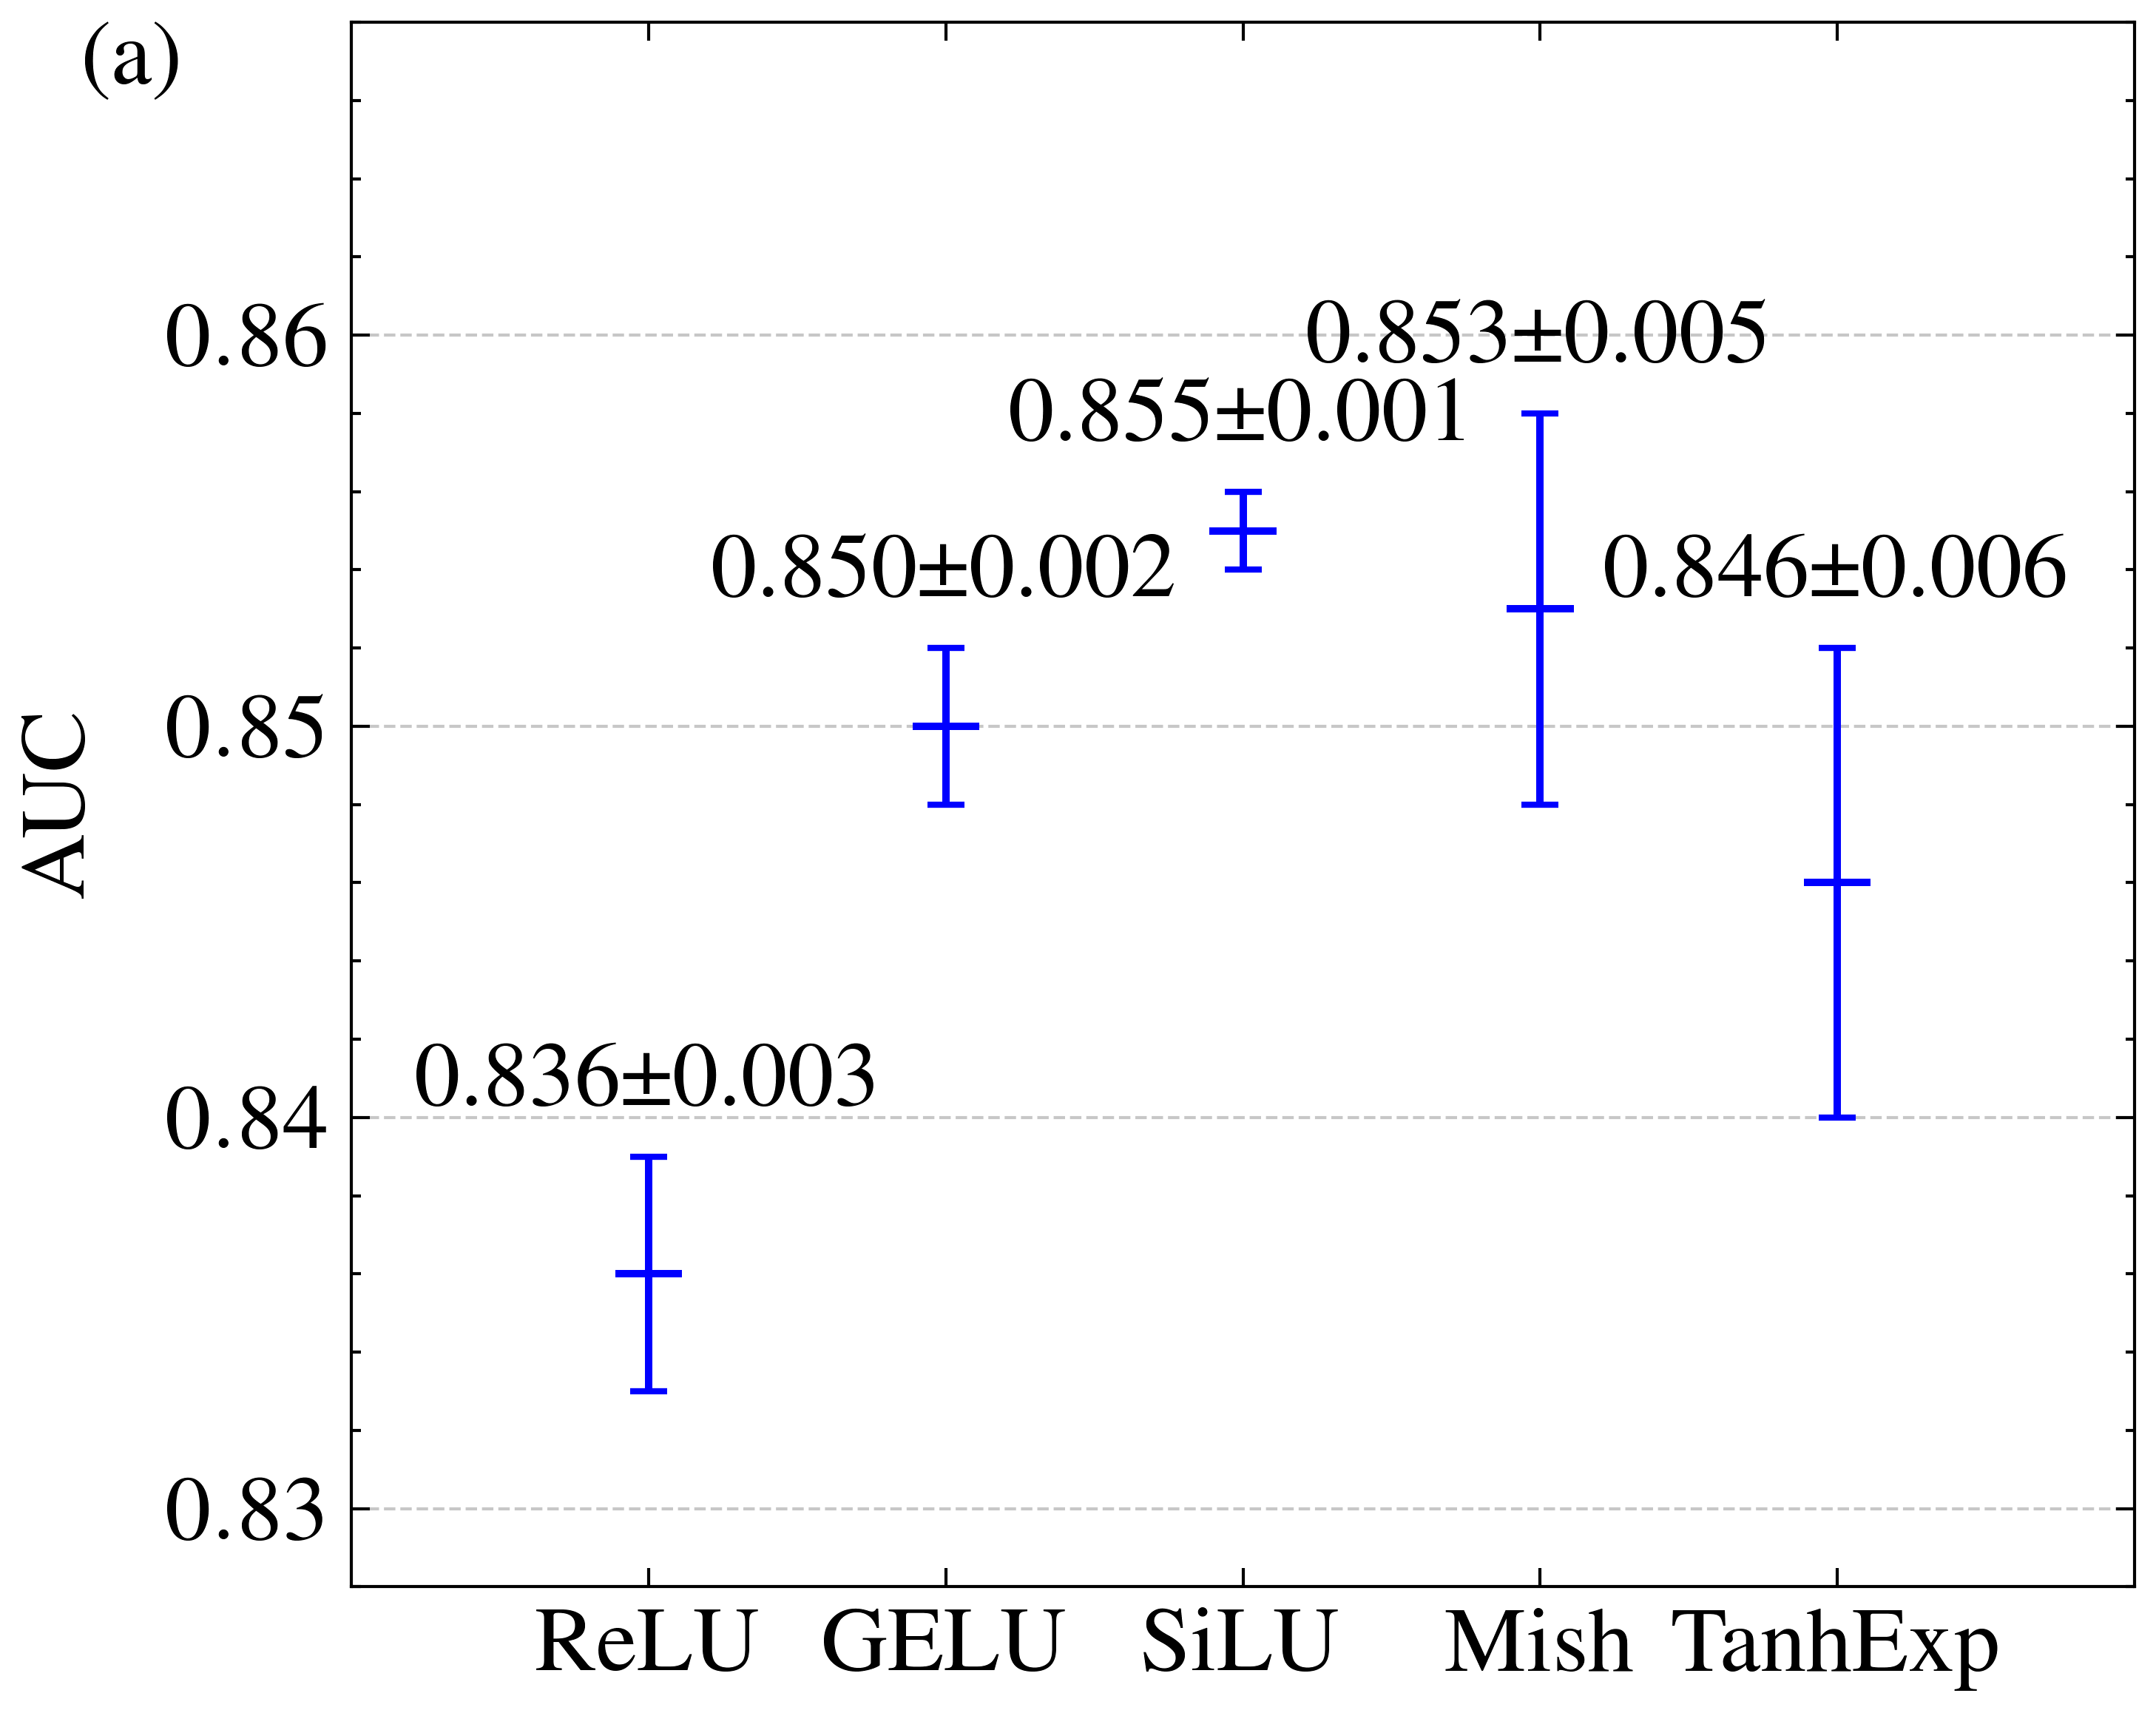

In [66]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib as mpl
import scienceplots

# 禁用LaTeX渲染以避免中文问题
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
plt.style.use(['science', 'ieee'])

# 激活函数及其AUC结果数据
activation_functions = ['ReLU', 'GELU', 'SiLU', 'Mish', 'TanhExp']
auc_means = [0.836, 0.850, 0.855, 0.853, 0.846]
auc_stds = [0.003, 0.002, 0.001, 0.005, 0.006]

# 创建图形和轴
fig, ax = plt.subplots(figsize=(5, 4))

# 设置x坐标位置
x = np.arange(len(activation_functions))

# 调窄矩形和误差条的宽度
width = 0.3 # 更窄的宽度

# 创建灰度颜色列表，使用不同的深浅
gray_levels = np.linspace(0.2, 0.8, len(activation_functions)) # 从浅到深的灰度
colors = [plt.cm.gray(level) for level in gray_levels]

# 同时显示矩形范围和误差条
for i in range(len(activation_functions)):
  # 计算下限和上限
  lower = auc_means[i] - auc_stds[i]
  upper = auc_means[i] + auc_stds[i]
  
  # 绘制显示误差范围的矩形，使用灰度颜色
 # rect = plt.Rectangle((x[i] - width/2, lower), width, upper - lower,
 #           color=colors[i], alpha=1.0) # 调整透明度
 # ax.add_patch(rect)
  
  # 在矩形中心添加均值线
  ax.plot([x[i] - width/3, x[i] + width/3], [auc_means[i], auc_means[i]],
      color='blue', linestyle='-', linewidth=1.2) # 稍微减小线宽
  
  # 使用errorbar函数绘制误差条
  ax.errorbar(x[i], auc_means[i], yerr=auc_stds[i], fmt='none',
        color='blue', capsize=3, capthick=1, linestyle='-', linewidth=1.2) # 调整端帽大小和线宽
  
  # 添加数值标签
  ax.annotate(f'{auc_means[i]:.3f}±{auc_stds[i]:.3f}',
        xy=(x[i], upper),
        xytext=(0, 5), # 5点垂直偏移
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=15)

# 设置标题和轴标签
ax.set_ylabel('AUC', fontsize=15, labelpad=10)

# 设置x轴刻度和标签
ax.set_xticks(x)
ax.set_xticklabels(activation_functions, fontsize=15)
ax.tick_params(axis='y', labelsize=15) # y轴刻度标签字体大小
ax.xaxis.set_minor_locator(plt.NullLocator())

# 设置y轴范围，使图表更清晰
y_min = min([m - s for m, s in zip(auc_means, auc_stds)]) - 0.005
y_max = max([m + s for m, s in zip(auc_means, auc_stds)]) + 0.01
ax.set_ylim(y_min, y_max)

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# 设置x轴范围，增加两侧空白
ax.set_xlim(x[0] - 1, x[-1] + 1) # 关键行：增加x轴范围

# 添加 (a) 标记
ax.text(-0.15, 1.0, '(a)', transform=ax.transAxes, fontsize=15, va='top')

# 调整布局
plt.tight_layout()

# 保存为EPS文件
plt.savefig('D:/Credit Card Fraud Detection/Fig2a.eps', format='eps', dpi=800)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


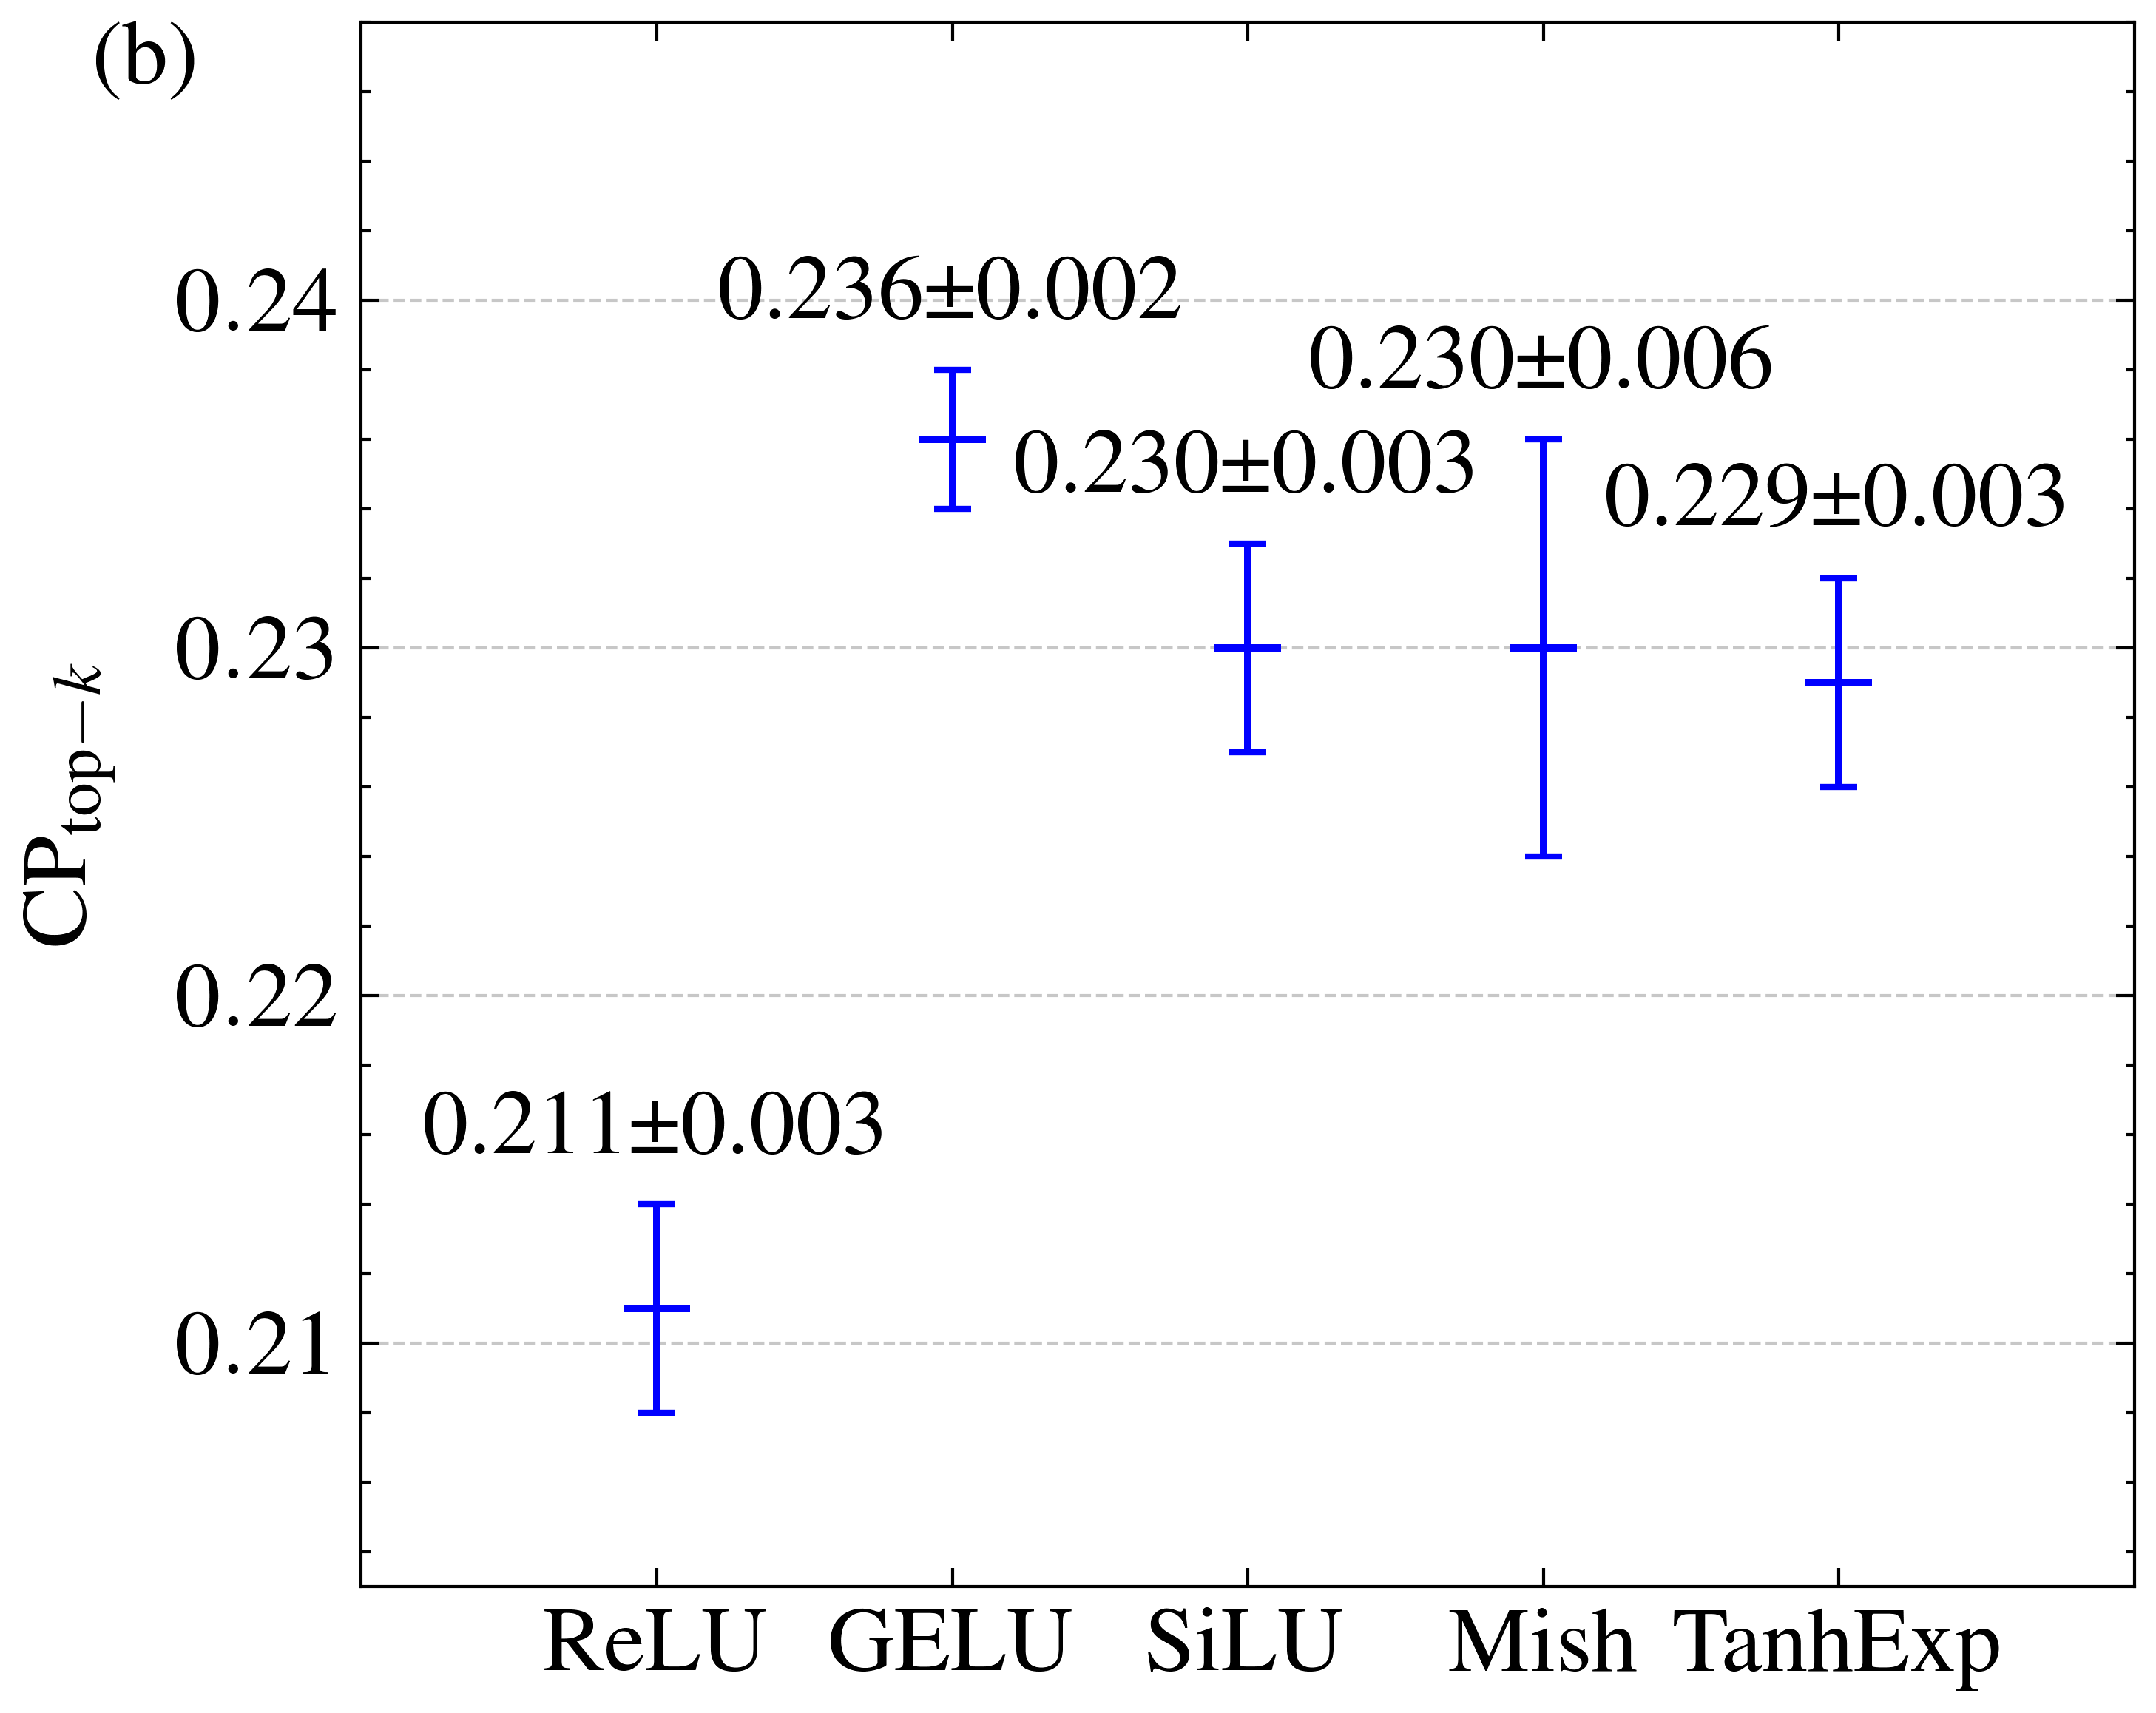

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib as mpl
import scienceplots

# 禁用LaTeX渲染以避免中文问题
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
plt.style.use(['science', 'ieee'])

# 激活函数及其AUC结果数据
activation_functions = ['ReLU', 'GELU', 'SiLU', 'Mish', 'TanhExp']
auc_means = [0.211, 0.236, 0.230, 0.230, 0.229] # 修改后的均值
auc_stds = [0.003, 0.002, 0.003, 0.006, 0.003] # 修改后的标准差

# 创建图形和轴
fig, ax = plt.subplots(figsize=(5, 4))

# 设置x坐标位置
x = np.arange(len(activation_functions))

# 调窄矩形和误差条的宽度
width = 0.3 # 更窄的宽度

# 创建灰度颜色列表，使用不同的深浅
gray_levels = np.linspace(0.2, 0.8, len(activation_functions)) # 从浅到深的灰度
colors = [plt.cm.gray(level) for level in gray_levels]

# 同时显示矩形范围和误差条
for i in range(len(activation_functions)):
  # 计算下限和上限
  lower = auc_means[i] - auc_stds[i]
  upper = auc_means[i] + auc_stds[i]
  
  # 在矩形中心添加均值线
  ax.plot([x[i] - width/3, x[i] + width/3], [auc_means[i], auc_means[i]],
      color='blue', linestyle='-', linewidth=1.2) # 稍微减小线宽
  
  # 使用errorbar函数绘制误差条
  ax.errorbar(x[i], auc_means[i], yerr=auc_stds[i], fmt='none',
        color='blue', capsize=3, capthick=1, linestyle='-', linewidth=1.2) # 调整端帽大小和线宽
  
  # 添加数值标签
  ax.annotate(f'{auc_means[i]:.3f}±{auc_stds[i]:.3f}',
        xy=(x[i], upper),
        xytext=(0, 5), # 5点垂直偏移
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=15)

# 设置标题和轴标签
ax.set_ylabel(r'CP$_{\rm top-{\it k}}$', fontsize=15, labelpad=10)

# 设置x轴刻度和标签
ax.set_xticks(x)
ax.set_xticklabels(activation_functions, fontsize=15)
ax.tick_params(axis='y', labelsize=15) # y轴刻度标签字体大小
ax.xaxis.set_minor_locator(plt.NullLocator())

# 设置y轴范围，使图表更清晰
y_min = min([m - s for m, s in zip(auc_means, auc_stds)]) - 0.005
y_max = max([m + s for m, s in zip(auc_means, auc_stds)]) + 0.01
ax.set_ylim(y_min, y_max)

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# 设置x轴范围，增加两侧空白
ax.set_xlim(x[0] - 1, x[-1] + 1) # 关键行：增加x轴范围

# 添加 (a) 标记
ax.text(-0.15, 1.0, '(b)', transform=ax.transAxes, fontsize=15, va='top')

# 调整布局
plt.tight_layout()

# 保存为EPS文件
plt.savefig('D:/Credit Card Fraud Detection/Fig2b.eps', format='eps', dpi=800)

plt.show()